# Data Analysis

The preprocessing notebook was used to create a dataset, collecting power and traffic data of basic email operations, called functional units, under different conditions — different providers, use of ad-blockers and PGP encryption.

In this notebook, we do a statistical analysis of this dataset using graphs to interprete and compare the impact of different factors: the choice of provider, use of ad-blockers and PGP encryption.

### Importing libraries

In [2]:
import pandas as pd # For data manipulation
import numpy as np # For data manipulation
import requests # For HTTP Requests to the API
import seaborn as sns # For charts
from IPython.display import display # To dataframe displaying
import scipy.stats as stats # For stats
import pingouin as pg # For stats
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from datetime import datetime, timezone
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

#Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the width
pd.set_option('display.max_colwidth', None)  # Show full content of each column

### Defining Constants

- We use a DataFrame to map each (provider, adblock condition, pgp condition, functional unit) combination to the corresponding test name and the action to monitor within those tests.

    EXAMPLE:
    - Considering the 'reply' functional unit for the 'gmail' provider with adblock enabled, we look up the entry `['gmail', 'enabled', 'disabled', 'reply']`. This entry directs us to the test name `'2025_gmail_session_adblock.json'` and specifies the action to monitor: `'reply'`.

    - Considering the 'attachment' functional unit (i.e., send with attachment file) for the 'mysolution' provider with adblock disabled and PGP enabled, we look up the entry `['mysolution', 'disabled', 'enabled', 'attachment']`. This entry directs us to the test name `'2025_mysolution_session_nopgp.json'` and specifies the action to monitor: `'send_mail_5MB'`.


In [5]:
PROVIDERS = ['gmail', 'outlook', 'proton', 'self-hosted solution (remote emulation)', 'self-hosted solution']
ADBLOCK_CONDITION = ['enabled', 'disabled']
PGP_CONDITIONS = ['enabled', 'disabled']
FUNCTIONAL_UNITS = ['login', 'logout', 'noattachment', 'attachment', 'read', 'reply', 'delete', 'session']

    
def get_test_name_and_action(provider, adblock, pgp, functional_unit):

    test_name = "2025_"
    action = None
    latency = False

    if 'self-hosted solution' in provider:
        test_name += 'mysolution_session_'
        test_name += 'noadblock'
        test_name += '_pgp' if pgp == 'enabled' else '_nopgp'
        if 'on_site' in provider:
            test_name += '_on_site'
        elif 'remote' in provider:
            test_name += '_remote50'
    else:
        test_name += f"{provider}_session_"
        test_name += 'adblock' if adblock == 'enabled' else 'noadblock'

    test_name += '.json'

    if functional_unit == 'login':
        action = 'login'
    elif functional_unit == 'logout':
        action = 'logout'
    elif functional_unit == 'attachment':
        action = 'send_mail_5MB'
    elif functional_unit == 'noattachment':
        action = 'send_mail_0MB'
    elif functional_unit == 'read':
        action = 'read_first'
    elif functional_unit == 'reply':
        action = 'reply'
    elif functional_unit == 'delete':
        action = 'delete_first'
    elif functional_unit == 'session':
        action = 'session'


    return test_name, action

    
# Generate all combinations of provider, adblock, pgp, and functional_unit
tests_and_actions = [
    [provider, adblock, pgp, functional_unit] + list(get_test_name_and_action(provider, adblock, pgp, functional_unit))
    for provider in PROVIDERS
    for adblock in ADBLOCK_CONDITION
    for pgp in PGP_CONDITIONS
    for functional_unit in FUNCTIONAL_UNITS
    if not (pgp == 'enabled' and not 'self-hosted solution' in provider)  # Exclude 'enabled' PGP for all providers except 'mysolution'
    if not ('self-hosted solution' in provider and adblock == 'enabled') # Exclude 'enabled' ADBLOCK for provider 'mysolution'
]

# Create the DataFrame
TESTS_AND_ACTIONS = (pd.DataFrame(tests_and_actions, columns=['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT', 'TEST', 'ACTION']) \
    .set_index(['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT']))

TESTS_AND_ACTIONS

TEST  \
PROVIDER                                ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT                                                          
gmail                                   enabled           disabled      login                                  2025_gmail_session_adblock.json   
                                                                        logout                                 2025_gmail_session_adblock.json   
                                                                        noattachment                           2025_gmail_session_adblock.json   
                                                                        attachment                             2025_gmail_session_adblock.json   
                                                                        read                                   2025_gmail_session_adblock.json   
                                                                        reply                                  2025_gmail_session_adblock.json   
                                                                        delete                                 2025_gmail_session_adblock.json   
                                                                        session                                2025_gmail_session_adblock.json   
                                        disabled          disabled      login                                2025_gmail_session_noadblock.json   
                                                                        logout                               2025_gmail_session_noadblock.json   
                                                                        noattachment                         2025_gmail_session_noadblock.json   
                                                                        attachment                           2025_gmail_session_noadblock.json   
                                                                        read                                 2025_gmail_session_noadblock.json   
                                                                        reply                                2025_gmail_session_noadblock.json   
                                                                        delete                               2025_gmail_session_noadblock.json   
                                                                        session                              2025_gmail_session_noadblock.json   
outlook                                 enabled           disabled      login                                2025_outlook_session_adblock.json   
                                                                        logout                               2025_outlook_session_adblock.json   
                                                                        noattachment                         2025_outlook_session_adblock.json   
                                                                        attachment                           2025_outlook_session_adblock.json   
                                                                        read                                 2025_outlook_session_adblock.json   
                                                                        reply                                2025_outlook_session_adblock.json   
                                                                        delete                               2025_outlook_session_adblock.json   
                                                                        session                              2025_outlook_session_adblock.json   
                                        disabled          disabled      login                              2025_outlook_session_noadblock.json   
                                                                        logout                             2025_outlook_session_noadblock.json   
                                                  

- Defining the metrics and their units

In [6]:
METRICS = [
    'CPU_ENERGY',                   # cpu_energy_rapl_msr_component
    'MEMORY_ENERGY',                # memory_energy_rapl_msr_component
    'NETWORK_IO',                   # network_io_cgroup_container
    'ESTIMATED_MACHINE_ENERGY',     # psu_energy_ac_xgboost_machine
    'DURATION']

COMPUTED_METRICS = ['CPU_POWER',
                    'MEMORY_POWER',
                    'ESTIMATED_MACHINE_POWER']

TOTALS = [  'USE_PHASE_MACHINE_EMISSION',
            'EMBODIED_MACHINE_EMISSION',
            'USE_PHASE_NETWORK_EMISSION',
            'EMBODIED_NETWORK_EMISSION',
            'TOTAL'
        ]

UNITS = {
    'CPU_ENERGY': 'mJ',
    'MEMORY_ENERGY': 'mJ',
    'NETWORK_IO' : 'Byte',
    'ESTIMATED_MACHINE_ENERGY' : 'mJ',
    'DURATION' : 'µs',
    'CPU_POWER' : 'W',
    'MEMORY_POWER' : 'W',
    'ESTIMATED_MACHINE_POWER' : 'W',
    'USE_PHASE_MACHINE_EMISSION' : 'gCO2e',
    'EMBODIED_MACHINE_EMISSION' : 'gCO2e',
    'USE_PHASE_NETWORK_EMISSION' : 'gCO2e',
    'EMBODIED_NETWORK_EMISSION' : 'gCO2e',
    'TOTAL' : 'gCO2e'
}

- **`count_distinct_samples`**: We define a function to count the samples for each scenario i.e., (provider, adblock condition, pgp condition, functional_unit) combination


In [240]:
def count_distinct_samples(data: pd.DataFrame):
    """
    Count the number of samples for each (provider, adblock condition, pgp condition, functional_unit) combination.

    Args:
        data (pd.DataFrame): The metadata DataFrame to count samples from.

    Returns:
        pd.DataFrame: A DataFrame containing the sample counts and missing sample counts.
    """
    return (data.groupby(['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT'])
                .agg(SAMPLE_COUNT=('START_TS', 'count'), 
                    MISSING_SAMPLES=('START_TS', lambda x: max(0, 100 - x.count())))  # Count missing samples
            )

- Load the dataset

In [241]:
data = pd.read_csv('2025_data_combined.csv')
data.head()

,TEST,RUN_ID,PROVIDER,ADBLOCK_CONDITION,PGP_CONDITION,FUNCTIONAL_UNIT,START_TS,DURATION,MEMORY_ENERGY,CPU_ENERGY,ESTIMATED_MACHINE_ENERGY,NETWORK_IO
0,2025_gmail_session_noadblock.json,092e9eec-4c2d-4cfd-84a7-93156d772f89,gmail,disabled,disabled,attachment,1740203675009547,75228436,90652,450527,1714959,6831822
1,2025_gmail_session_noadblock.json,092e9eec-4c2d-4cfd-84a7-93156d772f89,gmail,disabled,disabled,attachment,1740203385158546,69635873,84328,419778,1584170,6739654
2,2025_gmail_session_noadblock.json,092e9eec-4c2d-4cfd-84a7-93156d772f89,gmail,disabled,disabled,attachment,1740203107989707,63246760,76077,381621,1442723,6535961
3,2025_gmail_session_noadblock.json,092e9eec-4c2d-4cfd-84a7-93156d772f89,gmail,disabled,disabled,attachment,1740202826094987,66337463,80328,395633,1513092,6692779
4,2025_gmail_session_noadblock.json,092e9eec-4c2d-4cfd-84a7-93156d772f89,gmail,disabled,disabled,attachment,1740202527368683,71850814,86723,419925,1638538,6731685


- Remove outliers with IQR :

    The Interquartile Range (IQR) method is used to remove outliers because some measurements are disturbed by background processes affecting data transfer and power consumption. We ensure that we are left with at least 100 valid samples for each group.

In [242]:

def remove_outliers(data, columns, group_columns=['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT']):
    """
    Removes outliers from the dataframe using the IQR method per group (PROVIDER, FUNCTIONAL_UNIT).
    """
    # Iterate over each metric (column)
    for col in columns:
        # Define a function to remove outliers for each group
        def remove_outliers_for_group(group_df):
            Q1 = group_df[col].quantile(0.25)
            Q3 = group_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return group_df[(group_df[col] >= lower_bound) & (group_df[col] <= upper_bound)]
        
        # Apply the function to remove outliers for each group
        data = data.groupby(group_columns).apply(remove_outliers_for_group).reset_index(drop=True)
    
    return data

# Remove outliers
clean_data = remove_outliers(data, columns=METRICS)

# Display the numbers of valid samples left
count_distinct_samples(clean_data)

SAMPLE_COUNT  \
PROVIDER          ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT                 
gmail             disabled          disabled      attachment                196   
                                                  delete                     60   
                                                  login                     171   
                                                  logout                    146   
                                                  noattachment              159   
                                                  read                      373   
                                                  reply                     187   
                                                  session                   168   
                  enabled           disabled      attachment                149   
                                                  delete                     56   
                                                  login                     127   
                                                  logout                    111   
                                                  noattachment              119   
                                                  read                      288   
                                                  reply                     149   
                                                  session                   134   
mysolution        disabled          disabled      attachment                167   
                                                  delete                    101   
                                                  login                     162   
                                                  logout                    165   
                                                  noattachment              175   
                                                  read                      377   
                                                  reply                     189   
                                                  session                   146   
                                    enabled       attachment                125   
                                                  delete                    100   
                                                  login                     115   
                                                  logout                    133   
                                                  noattachment              134   
                                                  read                      275   
                                                  reply                     147   
                                                  session                   123   
mysolution_remote disabled          disabled      attachment                152   
                                                  delete                     89   
                                                  login                     154   
                                                  logout                    111   
                                                  noattachment              154   
                                                  read                      275   
                                                  reply                     130   
                                                  session                   117   
                                    enabled       attachment                 71   
                                                  delete                     58   
                                                  login                      83   
                                                  logout                     61   
                                                  noattachment               80   
                                                  read                      149   
                                                  reply                      77   


- Change the units to Joules, seconds and MegaBytes.
- Derive mean Power from Energy

In [243]:
def change_scale(data):
    for metric, unit in UNITS.items():
        if metric in data.columns:
            if unit == 'mJ':
                data[metric] = data[metric]/1e3
                UNITS[metric] = 'J'
            if unit == 'Byte':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 'MB'
            if unit == 'µs':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 's'
                
def get_power_data(data:pd.DataFrame):
    new_columns = ['CPU_POWER', 'MEMORY_POWER', 'ESTIMATED_MACHINE_POWER']
    columns = ['CPU_ENERGY', 'MEMORY_ENERGY', 'ESTIMATED_MACHINE_ENERGY']
    for i in range(len(new_columns)):
        data[new_columns[i]] = (data[columns[i]]/data['DURATION'])

In [244]:
change_scale(clean_data)
get_power_data(clean_data)

- Define a function to get the means and standard deviation of each scenario

In [245]:
def compute_means_and_stds(data:pd.DataFrame):

    return data.groupby(['PROVIDER', 'ADBLOCK_CONDITION', 'PGP_CONDITION', 'FUNCTIONAL_UNIT']) \
                .agg({  'DURATION': ['mean', 'std'],
                        'MEMORY_ENERGY': ['mean', 'std'],
                        'CPU_ENERGY': ['mean', 'std'],
                        'ESTIMATED_MACHINE_ENERGY': ['mean', 'std'],
                        'NETWORK_IO': ['mean', 'std'],
                        'MEMORY_POWER': ['mean', 'std'],
                        'CPU_POWER': ['mean', 'std'],
                        'ESTIMATED_MACHINE_POWER': ['mean', 'std'],
                    })

- Define a function to plot the mean and standard deviations

In [246]:
def plot_metrics_bars(means_and_stds: pd.DataFrame, metric: str, title=True, ylim=None):
    # Define colors for providers and conditions
    colors = {
        'gmail': {'adblock': '#ABB0AC', 'noadblock': '#636964'},
        'outlook': {'adblock': '#97BCD8', 'noadblock': '#366990'},
        'proton': {'adblock': '#F8B18B', 'noadblock': '#F26419'},
        'mysolution':{'pgp': "#cee07f", 'nopgp': "#a8af19"},
        'mysolution_remote':  {'pgp': '#FAD389', 'nopgp': '#F6AE2D'}

    }

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Get unique functional units and calculate positions for bars
    num_functional_units = len(FUNCTIONAL_UNITS)
    num_providers = len(PROVIDERS)

    # For each functional unit, count the number of provider-condition combinations (bars)
    # We'll use the MultiIndex to count unique (provider, adblock, pgp) for each functional unit
    provider_condition_combos = []
    for fu in FUNCTIONAL_UNITS:
        # Get all index tuples for this functional unit
        idxs = [idx for idx in means_and_stds.index if idx[3] == fu]
        provider_condition_combos.append(len(idxs))
    num_conditions = max(provider_condition_combos)

    fu_width = 1.0  # Width of one functional unit group on the x-axis
    fu_space = 0.15 * fu_width # Space between functional unit groups
    provider_space = 0 * (fu_width - fu_space) / num_providers # Space between providers group within a functional unit group
    bar_width = (fu_width - fu_space - num_providers * provider_space) / num_conditions  # Width of each bar

    # X-axis positions for each functional unit group
    fu_index = np.arange(num_functional_units) * fu_width

    # For each provider, assign a base offset (for visual grouping)
    providers_index = {provider: i * (fu_width - fu_space) / num_providers for i, provider in enumerate(PROVIDERS)}

    # Iterate over each functional unit to plot the bars
    for j, functional_unit in enumerate(FUNCTIONAL_UNITS):

        # get the rows for the current functional unit
        fu_rows = means_and_stds.xs(functional_unit, level='FUNCTIONAL_UNIT')

        # Iterate over each provider
        for k, provider in enumerate(PROVIDERS):

            # Get the rows for the current provider
            provider_rows = fu_rows.xs(provider, level='PROVIDER')

            # Iterate condition combinations for the current functional unit - provider
            for i, (idx, row) in enumerate(provider_rows.iterrows()):

                adblock, pgp = idx
                mean_value, std_value = row[metric]['mean'], row[metric]['std']

                # Determine the condition labels for adblock and pgp
                adblock_label = 'adblock' if adblock == 'enabled' else 'noadblock'
                pgp_label = 'pgp' if pgp == 'enabled' else 'nopgp'

                # Get the appropriate color for the given provider and condition
                if 'mysolution' in provider:
                    color = colors[provider].get(pgp_label, 'gray')  # Only pgp/nopgp for mysolution
                else:
                    color = colors.get(provider, {'adblock': 'gray', 'noadblock': 'darkgray'}).get(adblock_label, 'gray')

                # Calculate bar position based on functional unit and provider index + the bar offset
                bar_position = fu_index[j] + providers_index[provider] + i * bar_width

                # Label the first bar of each functional unit with provider/condition info
                label = f'{provider} - {adblock_label}/{pgp_label}' if j == 0 else None

                # Plot the bar and add error bars
                ax.bar(bar_position, mean_value, bar_width, color=color, edgecolor='k', label=label)
                ax.errorbar(bar_position, mean_value, yerr=std_value, fmt='o', color='black', capsize=5)
        
    # Set the labels with larger, bold fonts
    ax.set_xlabel('Functional Units', fontsize=20, fontweight='bold')
    ax.set_ylabel(f'{metric} ({UNITS.get(metric, "")})', fontsize=20, fontweight='bold')

    # Set the title with larger, bold font (optional if provided)
    if title:
        ax.set_title(f'Mean and Standard Dev of {metric} ({UNITS.get(metric,"")}) by Provider and Functional Unit',
                    fontsize=20, fontweight='bold')

    # Set x-ticks and rotate labels
    ax.set_xticks(fu_index + (fu_width - fu_space) / 2)
    ax.set_xticklabels(FUNCTIONAL_UNITS, rotation=45, ha='right', fontsize=17, fontweight='bold')

    # Add the legend with larger font
    ax.legend(fontsize=20)

    # Set y-axis limit if provided
    if ylim:
        ax.set_ylim(*ylim)

    # Improve layout
    plt.tight_layout()
    plt.show()

In [247]:
means_and_stds = compute_means_and_stds(clean_data)

selected = means_and_stds.loc[[('gmail', 'disabled', 'disabled', fu) for fu in FUNCTIONAL_UNITS] +
                              [('outlook', 'disabled', 'disabled', fu) for fu in FUNCTIONAL_UNITS] +
                              [('proton', 'disabled', 'disabled', fu) for fu in FUNCTIONAL_UNITS] +
                              [('mysolution_remote', 'disabled', 'enabled', fu) for fu in FUNCTIONAL_UNITS] +
                              [('mysolution', 'disabled', 'enabled', fu) for fu in FUNCTIONAL_UNITS]]

selected[['NETWORK_IO', 'ESTIMATED_MACHINE_ENERGY', 'ESTIMATED_MACHINE_POWER']]

NETWORK_IO  \
                                                                        mean   
PROVIDER          ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT              
gmail             disabled          disabled      login             1.134820   
                                                  logout            1.096508   
                                                  noattachment      1.520161   
                                                  attachment        6.705546   
                                                  read              0.088755   
                                                  reply             1.581909   
                                                  delete            0.000001   
                                                  session          13.146016   
outlook           disabled          disabled      login             1.237714   
                                                  logout            1.078044   
                                                  noattachment      2.099381   
                                                  attachment        7.085930   
                                                  read              0.127218   
                                                  reply             1.849556   
                                                  delete            0.001601   
                                                  session          15.134236   
proton            disabled          disabled      login             0.362250   
                                                  logout            0.135503   
                                                  noattachment      0.020584   
                                                  attachment        5.508042   
                                                  read              0.025560   
                                                  reply             0.022486   
                                                  delete            0.001460   
                                                  session           6.416018   
mysolution_remote disabled          enabled       login             0.054368   
                                                  logout            0.009256   
                                                  noattachment      0.082091   
                                                  attachment       11.282621   
                                                  read              0.021108   
                                                  reply             0.080890   
                                                  delete            0.000632   
                                                  session          11.720621   
mysolution        disabled          enabled       login             0.053748   
                                                  logout            0.009167   
                                                  noattachment      0.079468   
                                                  attachment       11.285000   
                                                  read              0.021060   
                                                  reply             0.078506   
                                                  delete            0.000001   
                                                  session          11.713420   

                                                                             \
                                                                        std   
PROVIDER          ADBLOCK_CONDITION PGP_CONDITION FUNCTIONAL_UNIT             
gmail             disabled          disabled      login            0.337196   
                                                  logout           0.026895   
                                                  noattachment     0.082625   
                                                  attachment       0.091788   
                                                  read             0.036

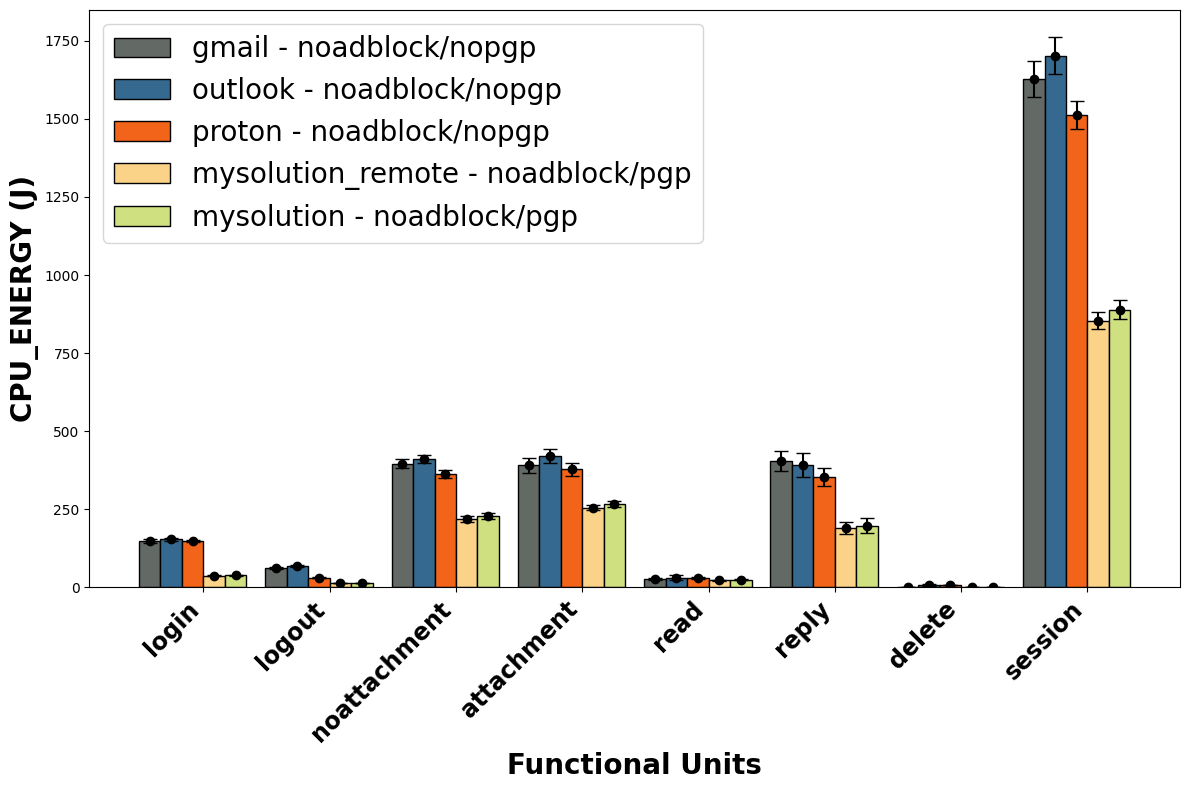

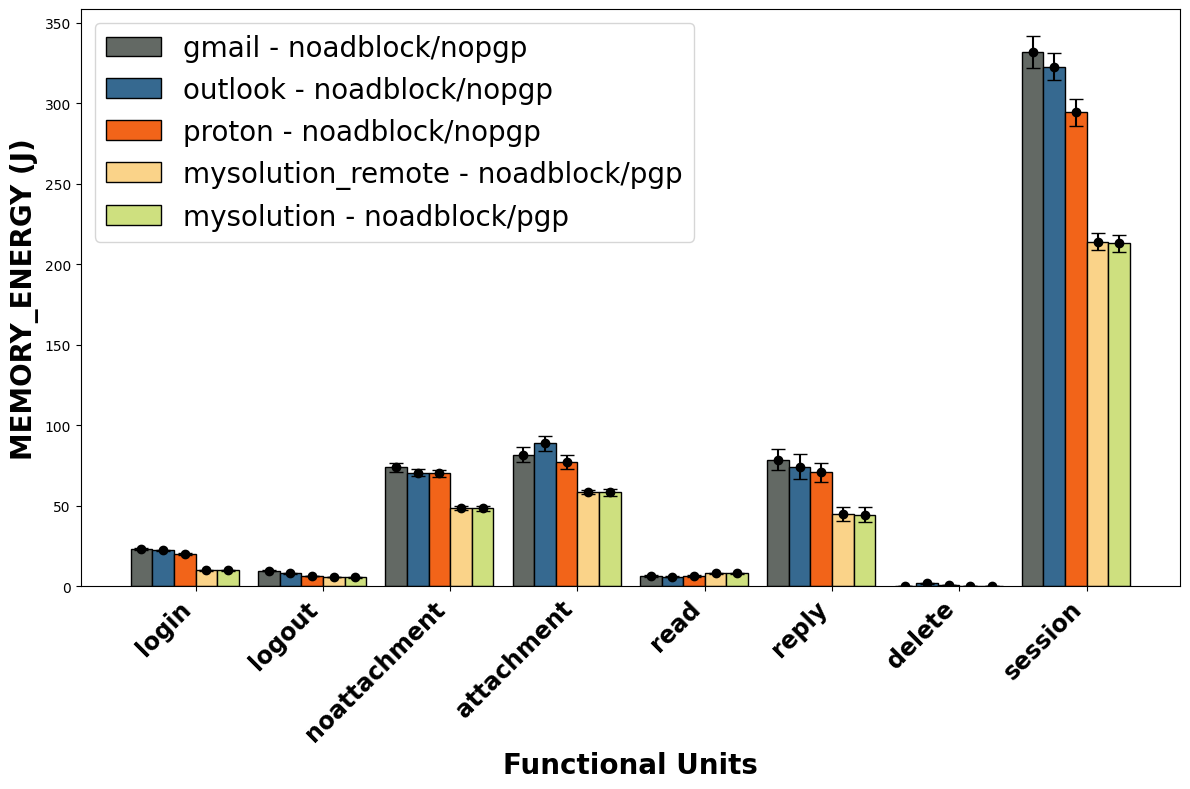

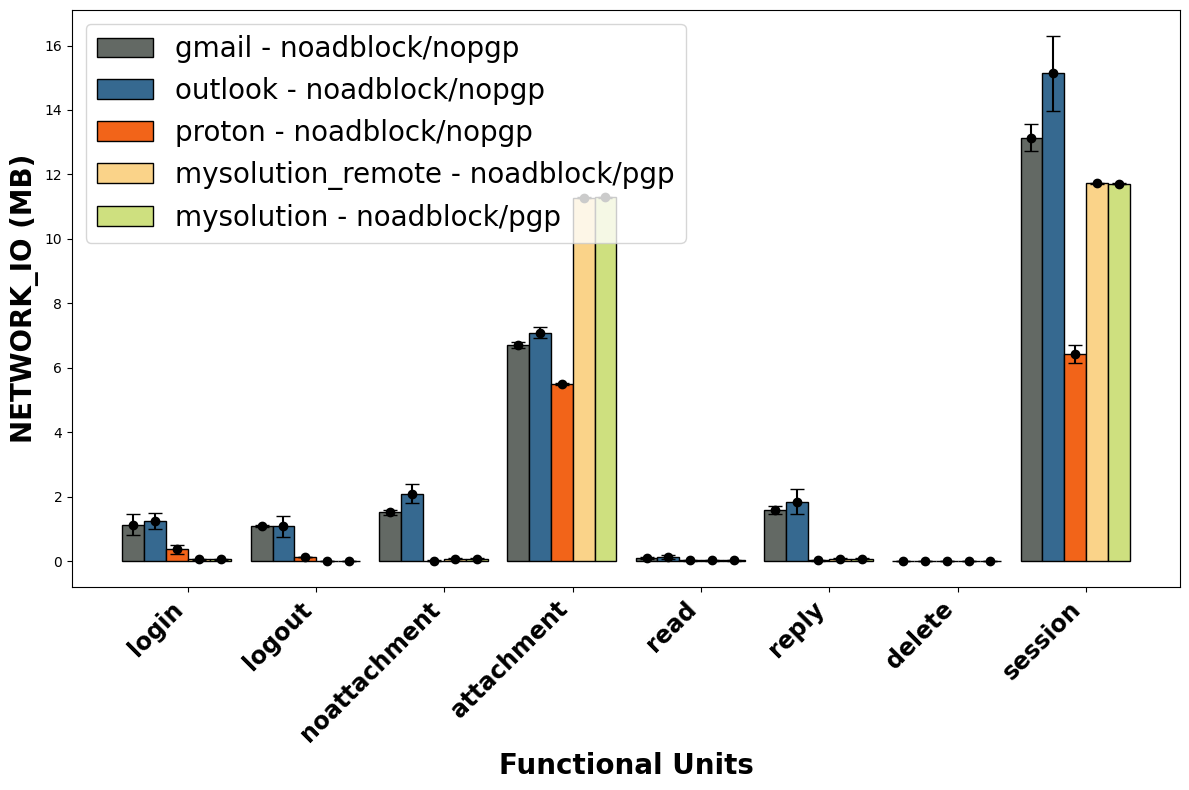

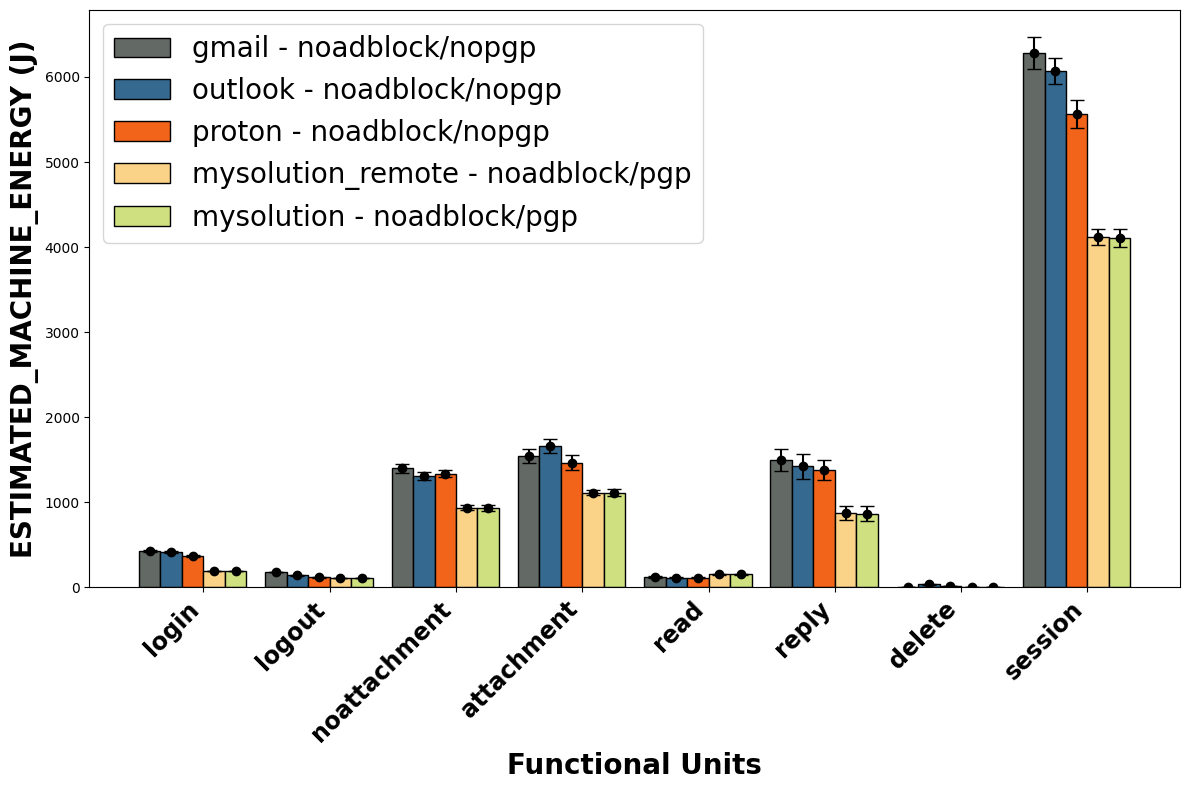

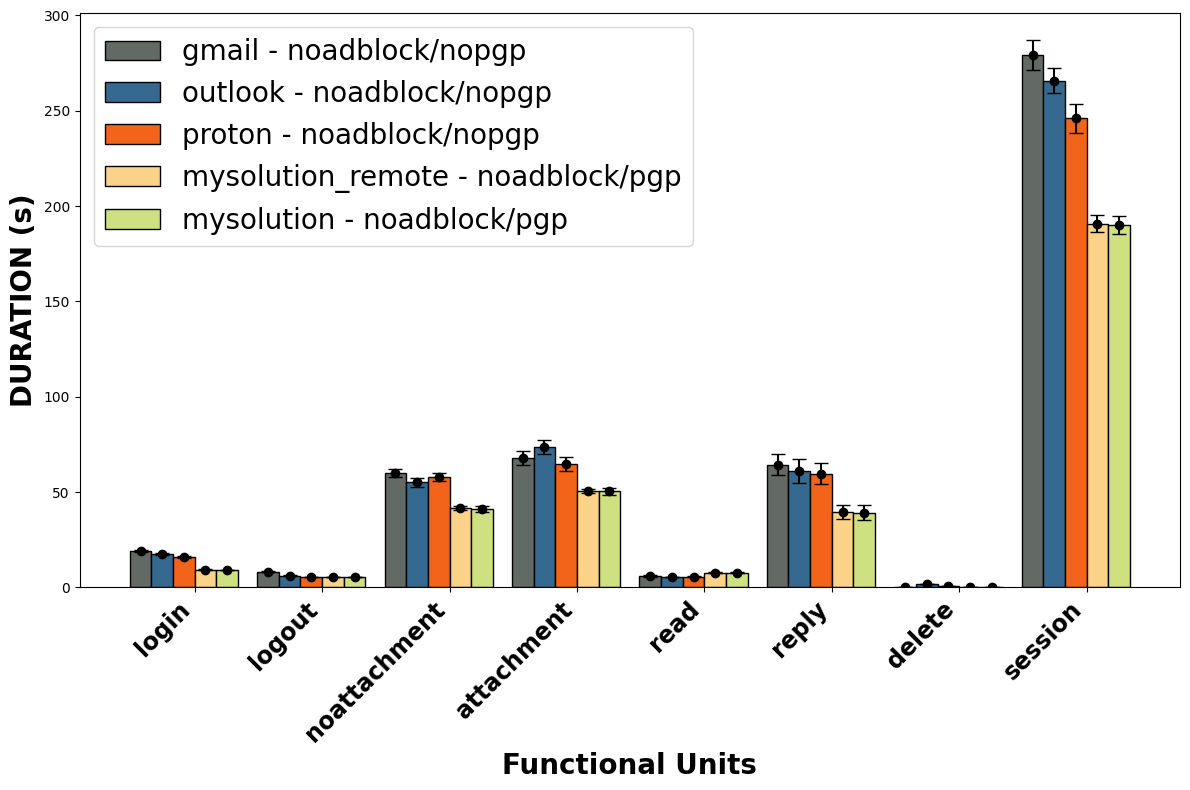

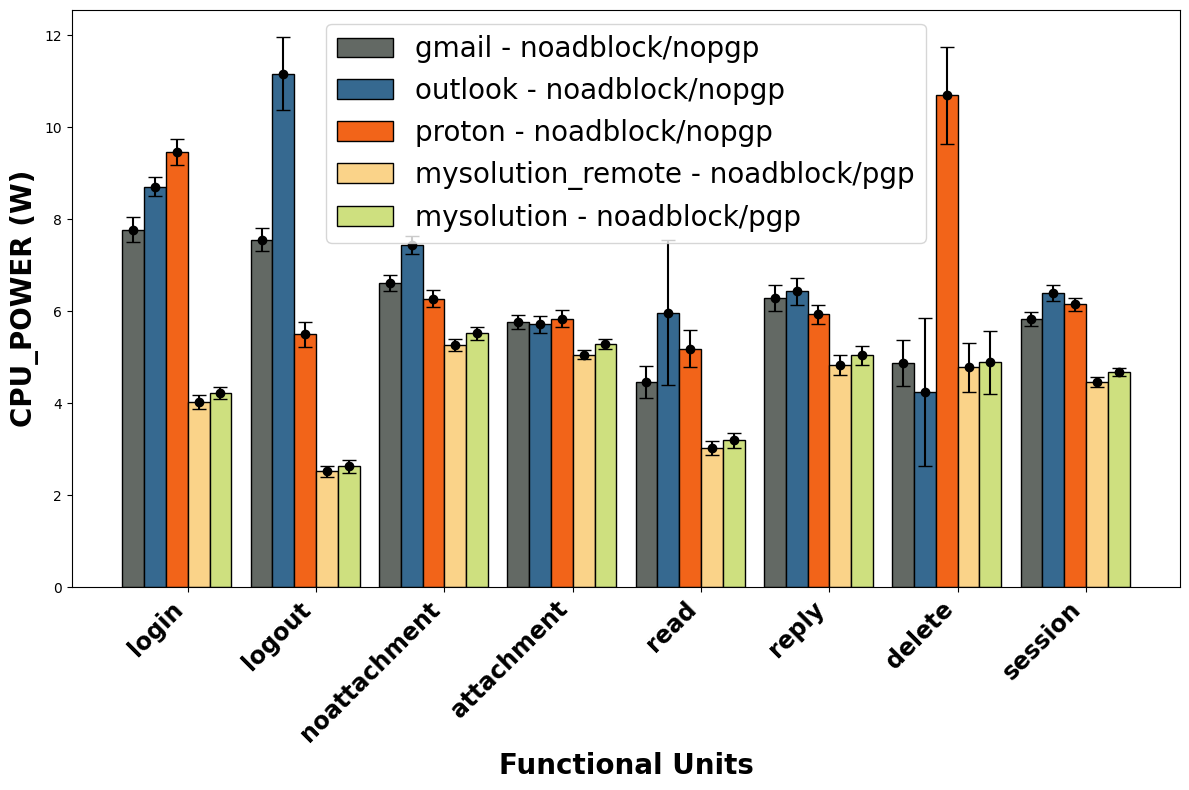

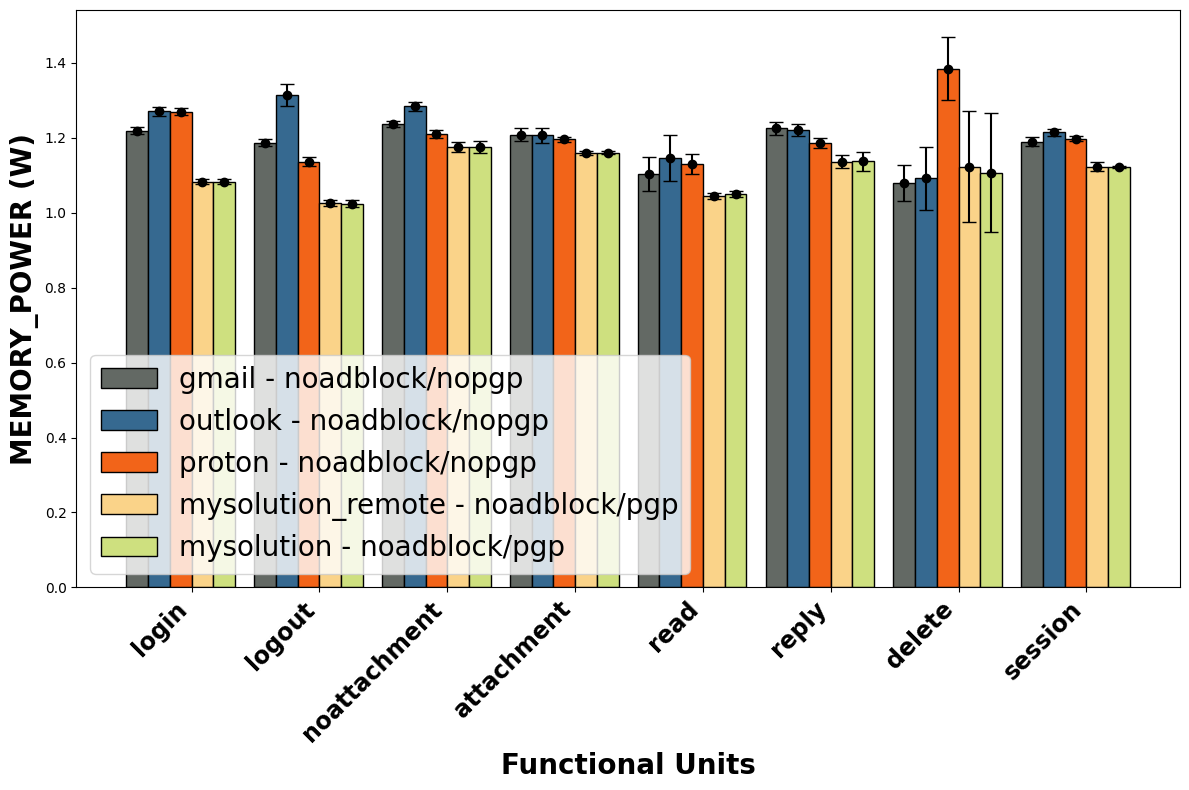

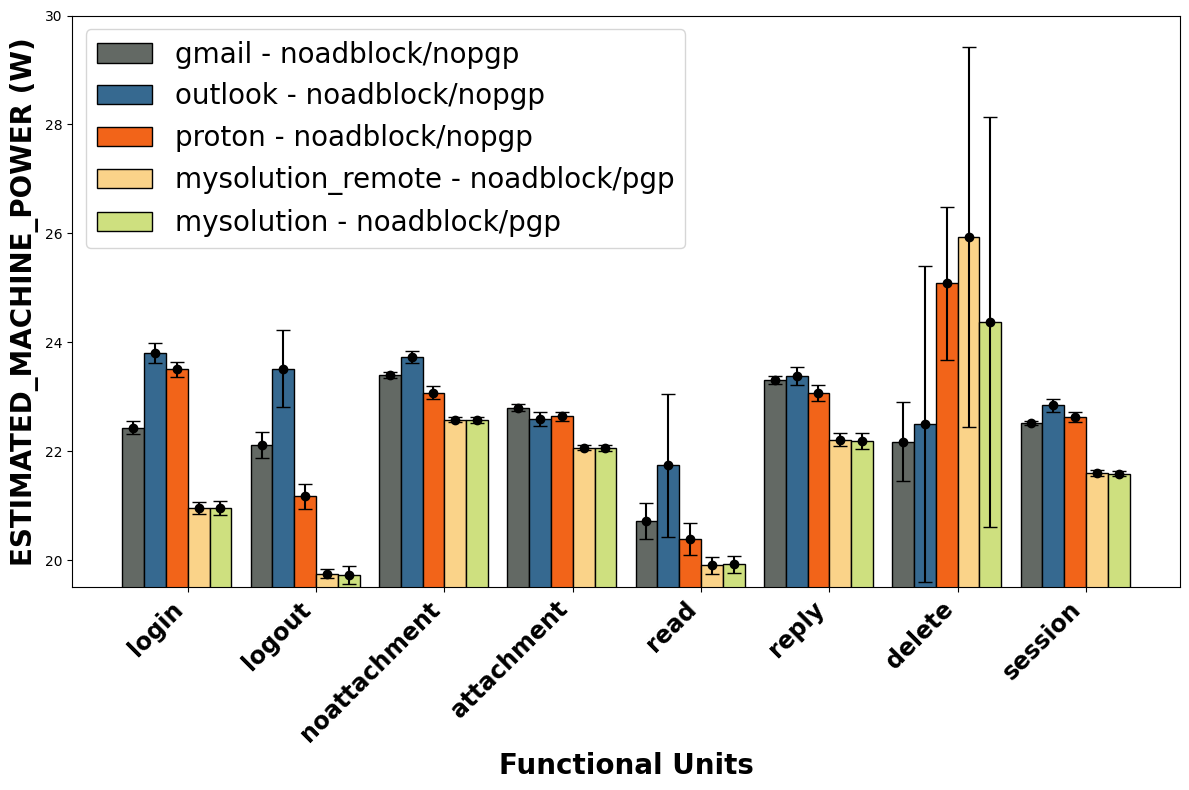

In [236]:
# PROVIDERS = ['gmail', 'outlook', 'proton', 'mysolution', 'mysolution_remote']
# ADBLOCK_CONDITION = ['enabled', 'disabled']
# PGP_CONDITIONS = ['enabled', 'disabled']
# FUNCTIONAL_UNITS = ['login', 'logout', 'noattachment', 'attachment', 'read', 'reply', 'delete', 'session']

# for metric in METRICS + COMPUTED_METRICS:
#     plot_metrics_bars(means_and_stds, metric)

PROVIDERS = ['gmail', 'outlook', 'proton', 'mysolution_remote', 'mysolution']
ADBLOCK_CONDITION = ['disabled']
PGP_CONDITIONS = ['enabled']
FUNCTIONAL_UNITS = ['login', 'logout', 'noattachment', 'attachment', 'read', 'reply', 'delete', 'session']

for metric in METRICS + COMPUTED_METRICS:
    ylim = (19.5, 30) if metric == "ESTIMATED_MACHINE_POWER" else None
    plot_metrics_bars(selected, metric, title=False, ylim=ylim)



### Statistically Significant Difference Testing

**Comparing scenarios:**

The function `compute_gains` compares 2 groups of samples.  It is used to compare different providers between them, or the effect of an ad-blocker or PGP encryption on a given provider. It uses an adequate paired t-test to determine if the differences in metrics between these conditions are statistically significant. Pairs of tests performed on the same website are considered dependent while otherwise independent

**Args:**
- `data (pd.DataFrame)`: Contains metrics for each scenario.
- `comparison_pair (dict)`: Contains the conditions to compare.
- `independence (bool)`: Indicates if the groups are independent or dependent.
- `metrics (list)`: List of metrics to compare.

**Returns:**
- `pd.DataFrame`: Results include gains and percentage gains for each action and provider.

**Plotting Results:**

The function `plot_gains` is used to visualise the gains or percentage gains or CO2 eq gains for each comparison. It highlights significant differences in metrics between the conditions.

**Args:**
- `gains (pd.DataFrame)`: DataFrame containing the gain results.
- `title (str)`: Title of the plot.
- `percentage (bool)`: Indicates if the gains are in percentage.
- `CO2 (bool)`: Indicates if the gains are in CO2 emissions.
- `label (str)`: Label for the plot.
- `figsize (tuple)`: Size of the plot.

In [179]:
def get_samples(data, functional_unit, provider, adblock='disabled', pgp='disabled',
                columns=METRICS+COMPUTED_METRICS):
    return data[(data['PROVIDER'] == provider) &
                (data['ADBLOCK_CONDITION'] == adblock) &
                (data['PGP_CONDITION'] == pgp) &
                (data['FUNCTIONAL_UNIT'] == functional_unit)][columns]

def verify_assumptions_and_perform_test(group_A, group_B, independence):
    """
    Verifies assumptions (normality, homogeneity of variance) and automatically performs 
    the appropriate parametric or non-parametric test using pingouin.

    Args:
    - group_A: Data for the first group.
    - group_B: Data for the second group.
    - independence: Boolean flag to indicate if the groups are independent (True) or dependent (False).

    Returns:
    - test_stat: Test statistic from the statistical test.
    - p_value: p-value from the statistical test.
    """
    
    # Automatically use pingouin to perform the correct t-test or non-parametric test
    if independence:
        result = pg.ttest(group_A, group_B, paired=False, correction="auto")
    else:
        result = pg.ttest(group_A, group_B, paired=True, correction="auto")
    
    # Extract p-value from the result
    p_value = result['p-val'].values[0]
    
    return p_value

def compute_gains(data, comparison_pair, independence, metrics = METRICS+COMPUTED_METRICS):
    """
    Loop over the comparisons and compute statistical test results, 
    applying assumption verification and appropriate statistical tests.
    """

    results = pd.DataFrame(index=metrics, columns=FUNCTIONAL_UNITS)
    percentage_results = pd.DataFrame(index=metrics, columns=FUNCTIONAL_UNITS)

    for functional_unit in FUNCTIONAL_UNITS:
        # Get the data samples for the current comparison
        test_A = get_samples(data, functional_unit, **comparison_pair['A'], columns=metrics)
        test_B = get_samples(data, functional_unit, **comparison_pair['B'], columns=metrics)

        # Ensure both groups have at least one sample
        if len(test_A) > 0 and len(test_B) > 0:

            # If the sizes differ, trim to the size of the smaller group
            min_size = min(len(test_A), len(test_B))
            test_A = test_A.iloc[:min_size]
            test_B = test_B.iloc[:min_size]

            # Perform the statistical test for each metric
            for metric in metrics:

                # Run the assumption check and statistical test
                p_value = verify_assumptions_and_perform_test(test_A[metric], test_B[metric], independence)

                # If the p-value is less than 0.05, compute the gain
                if p_value < 0.05:
                    
                    gain = test_A[metric].mean() - test_B[metric].mean()
                    percentage_gain = 100*(test_A[metric].mean() - test_B[metric].mean())/test_B[metric].mean()

                    results.loc[metric, functional_unit] = gain
                    percentage_results.loc[metric, functional_unit] = percentage_gain
                else:
                    results.loc[metric, functional_unit] = np.nan
                    percentage_results.loc[metric, functional_unit] = np.nan

    return results, percentage_results

def plot_gains(gains: pd.DataFrame, percentage: pd.DataFrame = None, title: str = None, CO2=False, figsize=(10, 3), fontsize=9):
    """
    Plots a comparison table showing both absolute gains and their percentage changes, or CO2e gains.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')


    def scale_value_unit(value, unit):
        """
        Scales the value and adjusts the unit based on magnitude.
        Base Units are : J, s, W, MB, MB/s
        """

        # Adjust CO2 units
        if CO2:
            if abs(value) > 1e9:
                value /= 1e9
                unit = 'ktCO2e'
            elif abs(value) > 1e6:
                value /= 1e6
                unit = 'tCO2e'
            elif abs(value) > 1e3:
                value /= 1e3
                unit = 'KgCO2e'
            elif abs(value) > 1:
                value /= value
                unit = 'gCO2e'
            elif abs(value) > 1e-3:
                value *= 1e3
                unit = 'mgCO2e'
            elif abs(value) > 1e-6:
                value *= 1e6
                unit = 'µgCO2e'
            return value, unit

        si_prefixes = [
            (1e9, 'G'),
            (1e6, 'M'),
            (1e3, 'k'),
            (1, ''),
            (1e-3, 'm'),
            (1e-6, 'µ')
        ]

    
        if unit in ['MB', 'MB/s']:
            value *= 1e6  # Convert MB to Byte for scaling
            base_unit = unit[1:]  # B, B/s
        else:
            base_unit = unit  # J, s, W


        for factor, prefix in si_prefixes:
            if abs(value) >= factor:
                scaled_value = value / factor
                return scaled_value, f"{prefix}{base_unit}"
        return value, unit  # fallback if no scaling applies


    def format_cell_value(value, percentage_value, unit):
        if np.isnan(value):
            return '-'

        value, unit = scale_value_unit(value, unit)
        
        sign = "+" if value > 0 else "-"
        text = f"{sign}{abs(value):.1f} {unit}"
        if percentage_value is not None:
            text += f" ({abs(percentage_value):.0f}%)"
        return text

    # Create combined formatted cell values and corresponding color map
    formatted_cells = []
    colourmap = []

    for i, metric in enumerate(gains.index):
        formatted_row = []
        color_row = []
        for j, functional_unit in enumerate(gains.columns):
            value = gains.iloc[i, j]
            percent = percentage.iloc[i, j] if percentage is not None else None

            formatted_row.append(format_cell_value(value, percent, UNITS.get(metric, '')))

            if isinstance(value, (int, float)) and not np.isnan(value):
                if metric == 'TOTAL':
                    if value < 0:
                        color_row.append('#199F19')
                    elif value > 0:
                        color_row.append('#CC8500')
                    else:
                        color_row.append('#adadad')
                else:
                    if value < 0:
                        color_row.append('#90EE90')
                    elif value > 0:
                        color_row.append('#FFB833')
                    else:
                        color_row.append('#FFFFFF')
                
            else:
                if metric == 'TOTAL':
                    color_row.append('#adadad')
                else:
                    color_row.append('white')

        formatted_cells.append(formatted_row)
        colourmap.append(color_row)


    table = ax.table(cellText=formatted_cells,
                     rowLabels=gains.index,
                     colLabels=gains.columns,
                     cellLoc='center',
                     loc='center',
                     cellColours=colourmap,
                     rowColours=['#949393' if index == "TOTAL" else '#ffffff' for index in gains.index]  # Darker gray for "TOTAL", light gray for others
    )
    
    # Get the row number corresponding to "TOTAL"
    total_row_index = gains.index.get_loc('TOTAL') + 1 if 'TOTAL' in gains.index else None

    for (row, col), cell in table.get_celld().items():
        # Align all text to the right
        cell.get_text().set_ha('right')

        # Bold column headers (row 0)
        if row == 0:
            cell.get_text().set_weight('bold')

        # Bold entire "TOTAL" row (including row label at col = -1)
        if total_row_index is not None and row == total_row_index:
            cell.get_text().set_weight('bold')

    plt.subplots_adjust(left=0, right=1)

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.auto_set_column_width
    table.scale(1.5, 1.6)
    if title is not None:
        print(title)
    plt.show()

- Define the set of pairs to compare and plot the tables

Effect of using Adblock - Gmail


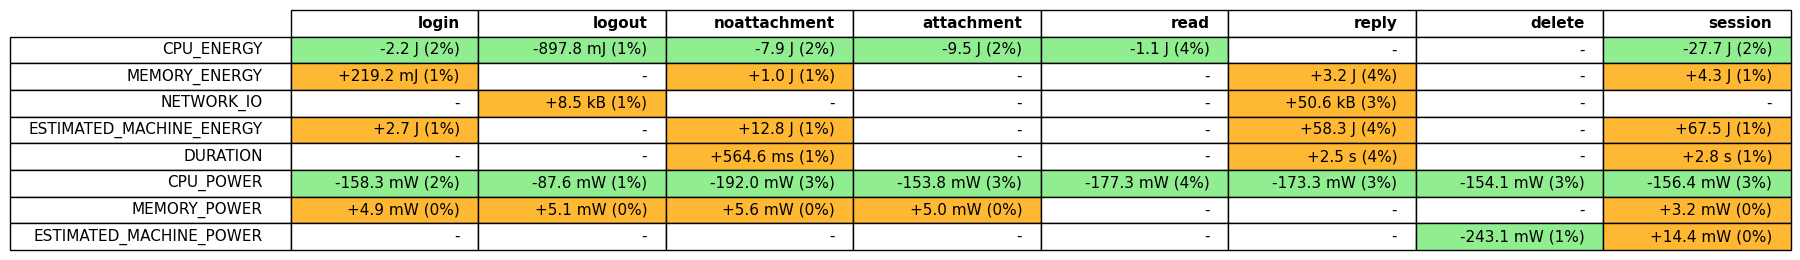

Effect of using Adblock - Outlook


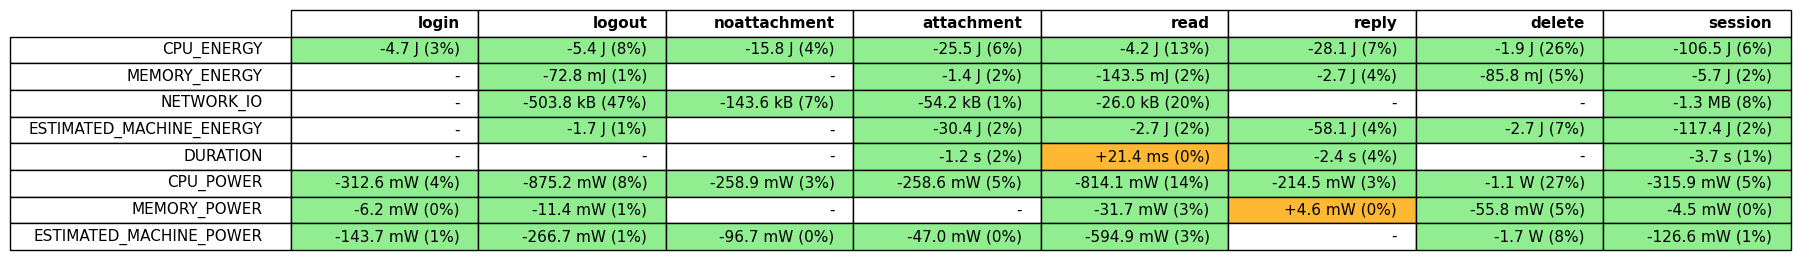

Effect of using Adblock - Proton


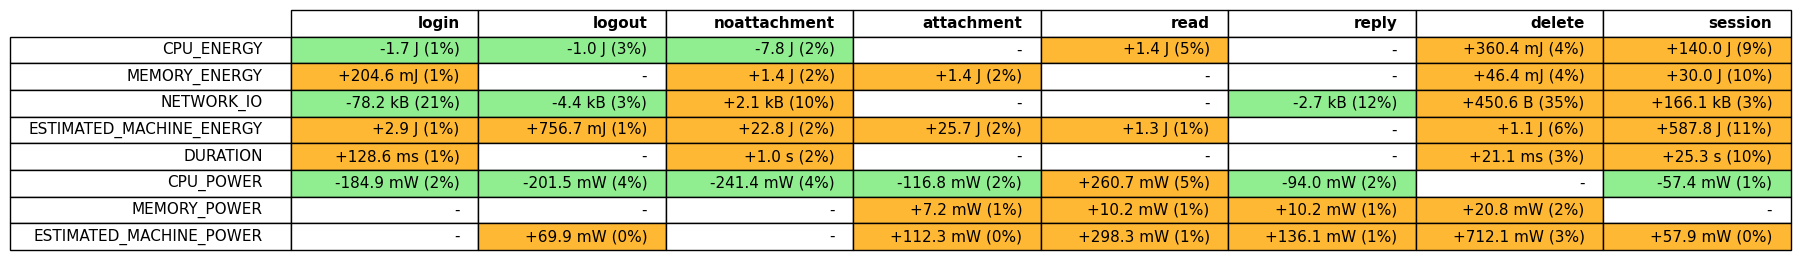

Effect of using PGP - MySolution


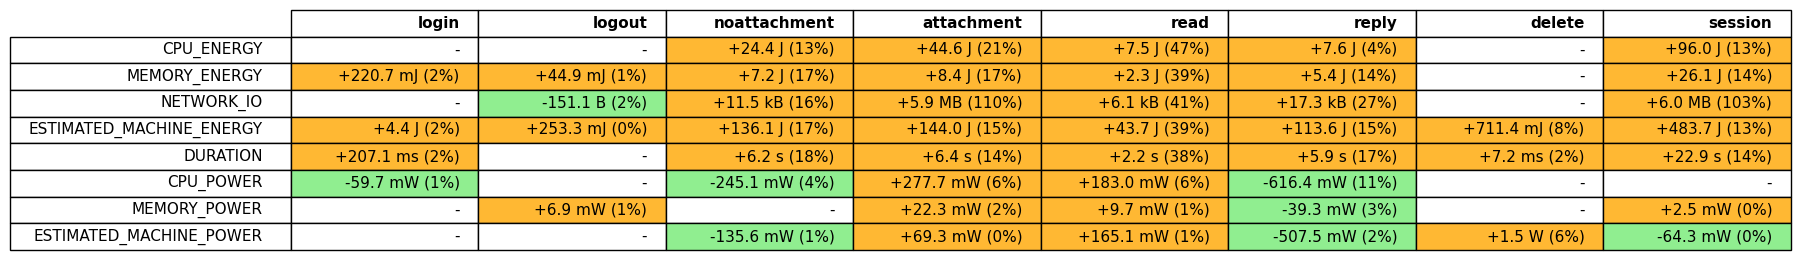

Effect of using Proton instead of Gmail


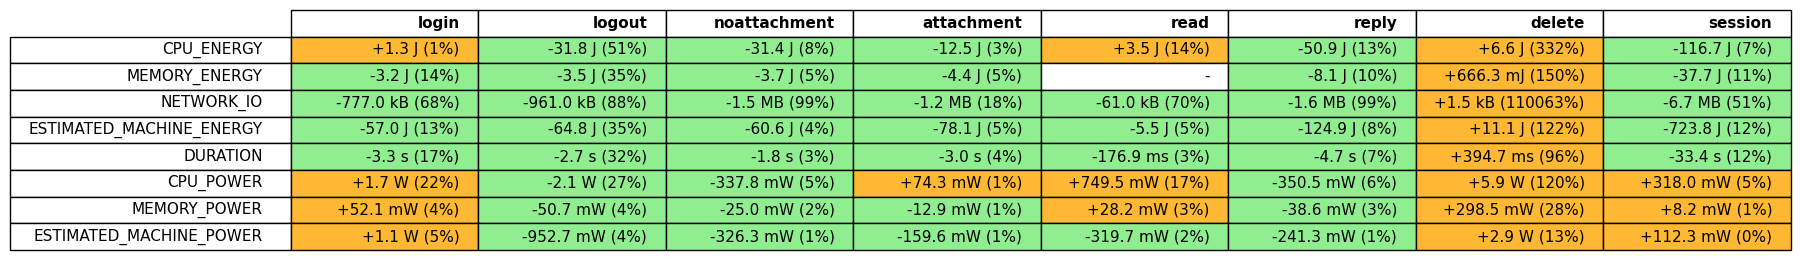

Effect of using Proton instead of Outlook


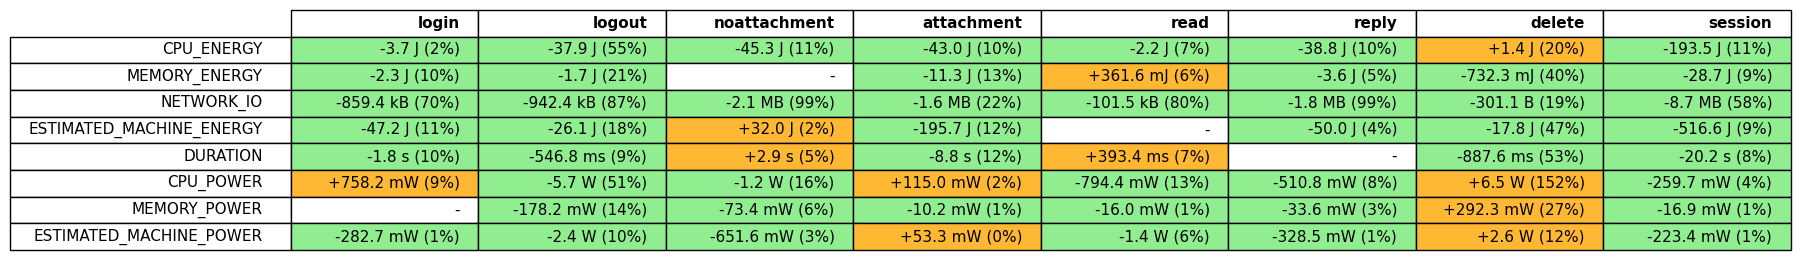

Effect of using Gmail instead of Outlook


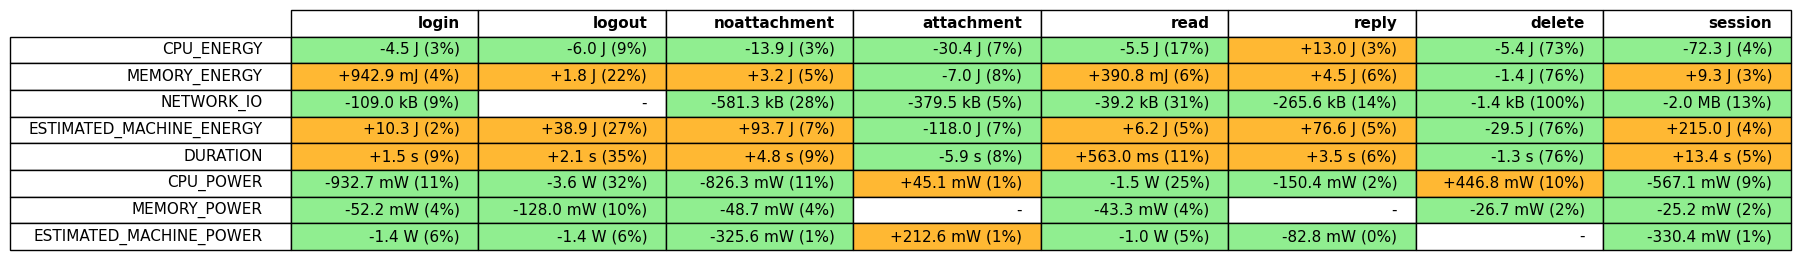

Effect of using MySolution (PGP activated) instead of Gmail


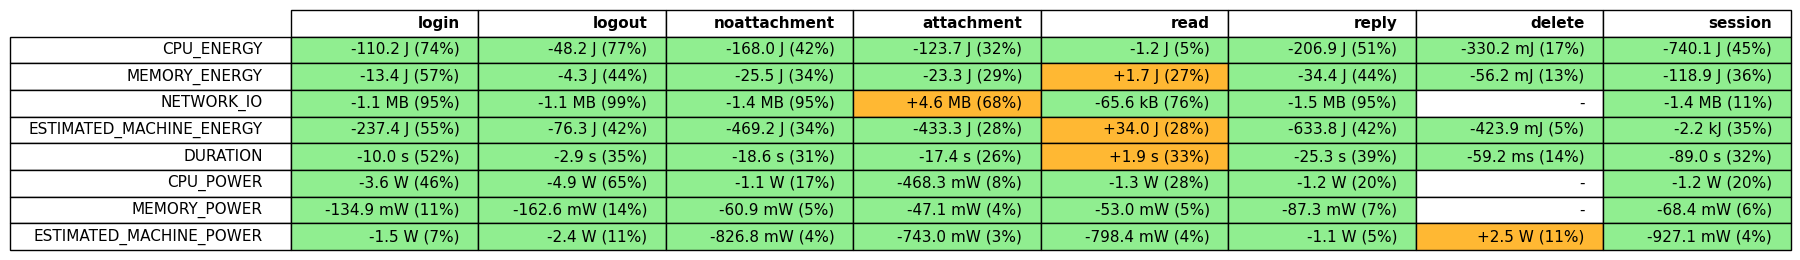

Effect of using MySolution (PGP activated) instead of Outlook


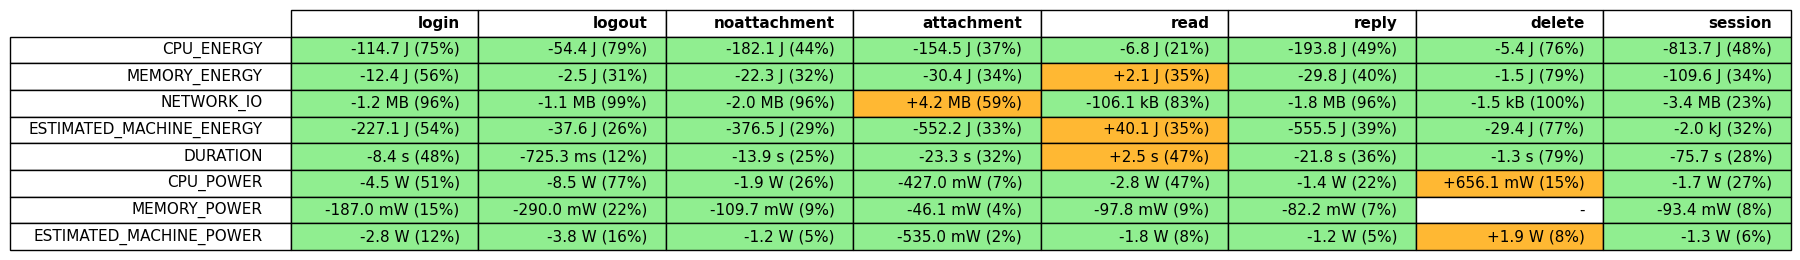

Effect of using MySolution (remotely - PGP activated) instead of Gmail


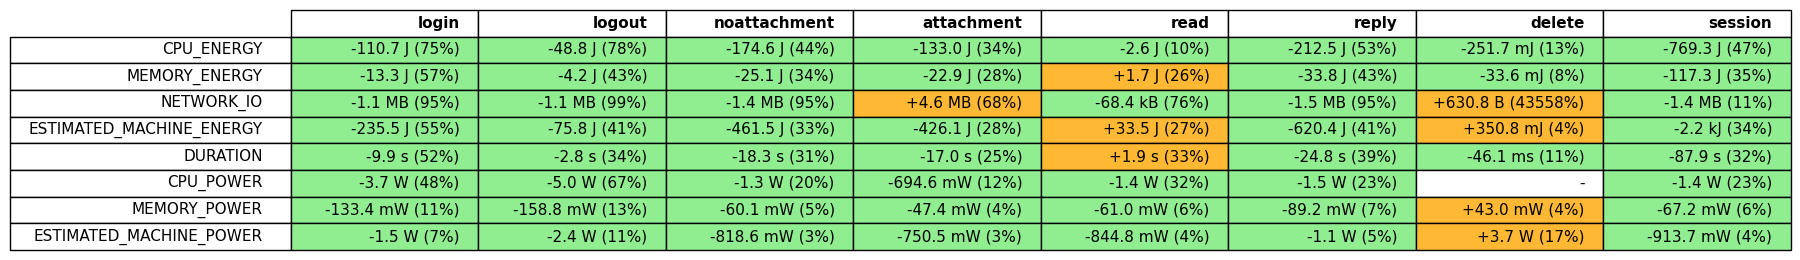

Effect of using MySolution (remotely - PGP activated) instead of Outlook


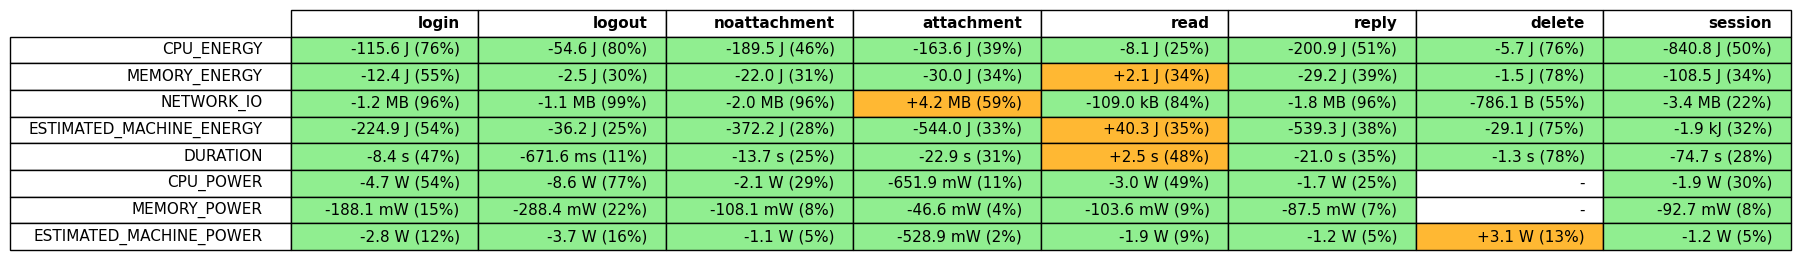

In [184]:
comparisons = {
    "Effect of using Adblock - Gmail": {
        'A': {'provider': 'gmail', 'adblock': 'enabled', 'pgp': 'disabled'},
        'B': {'provider': 'gmail', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using Adblock - Outlook": {
        'A': {'provider': 'outlook', 'adblock': 'enabled', 'pgp': 'disabled'},
        'B': {'provider': 'outlook', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using Adblock - Proton": {
        'A': {'provider': 'proton', 'adblock': 'enabled', 'pgp': 'disabled'},
        'B': {'provider': 'proton', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using PGP - MySolution": {
        'A': {'provider': 'mysolution_remote', 'adblock': 'disabled', 'pgp': 'enabled'},
        'B': {'provider': 'mysolution_remote', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using Proton instead of Gmail": {
        'A': {'provider': 'proton', 'adblock': 'disabled', 'pgp': 'disabled'},
        'B': {'provider': 'gmail', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using Proton instead of Outlook": {
        'A': {'provider': 'proton', 'adblock': 'disabled', 'pgp': 'disabled'},
        'B': {'provider': 'outlook', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using Gmail instead of Outlook": {
        'A': {'provider': 'gmail', 'adblock': 'disabled', 'pgp': 'disabled'},
        'B': {'provider': 'outlook', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using MySolution (PGP activated) instead of Gmail": {
        'A': {'provider': 'mysolution', 'adblock': 'disabled', 'pgp': 'enabled'},
        'B': {'provider': 'gmail', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using MySolution (PGP activated) instead of Outlook": {
        'A': {'provider': 'mysolution', 'adblock': 'disabled', 'pgp': 'enabled'},
        'B': {'provider': 'outlook', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using MySolution (remotely - PGP activated) instead of Gmail": {
        'A': {'provider': 'mysolution_remote', 'adblock': 'disabled', 'pgp': 'enabled'},
        'B': {'provider': 'gmail', 'adblock': 'disabled', 'pgp': 'disabled'}
    },
    "Effect of using MySolution (remotely - PGP activated) instead of Outlook": {
        'A': {'provider': 'mysolution_remote', 'adblock': 'disabled', 'pgp': 'enabled'},
        'B': {'provider': 'outlook', 'adblock': 'disabled', 'pgp': 'disabled'}
    }
}
for title, comparison_pair in comparisons.items():
    independence = True if 'against' in title else False
    gains, percentage_gains = compute_gains(clean_data, comparison_pair, independence)
    plot_gains(gains, percentage_gains, title=title, fontsize=11)



### Here we convert the mean measurment into GHG emissions
> Embodied Emission Calculation Formula

To calculate the embodied emissions on the user side, we use the formula:

**M = TE × (TR / EL) × RS**

Where:
- **M**: Embodied emissions
- **TE**: Total embodied emissions, meaning the sum of LCA emissions for all hardware components
- **TR**: Time reserved, meaning the length of time the hardware is reserved for use by the software - here this is the computed duration of the functional unit
- **EL**: Expected lifetime of the resources
- **RS**: Resources share - Here it's equal to 1 since we dedicate the whole machine to the functional unit (i.e. no hardware virtualisation)

Reference: [Green Software Foundation - SCI Guide](https://sci-guide.greensoftware.foundation/M/)

To calculate the network side embodied emissions, we use the overall ratio of embodied to use phase emissions and apply it to the network emissions:

`embodied_network_emissions = network_emissions * embodied_to_use_phase_ratio`

Effect of using Adblock - Gmail (CO2e)


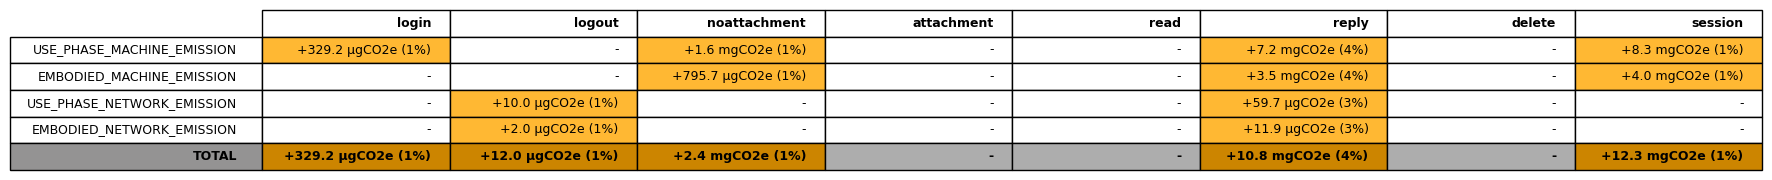

Effect of using Adblock - Outlook (CO2e)


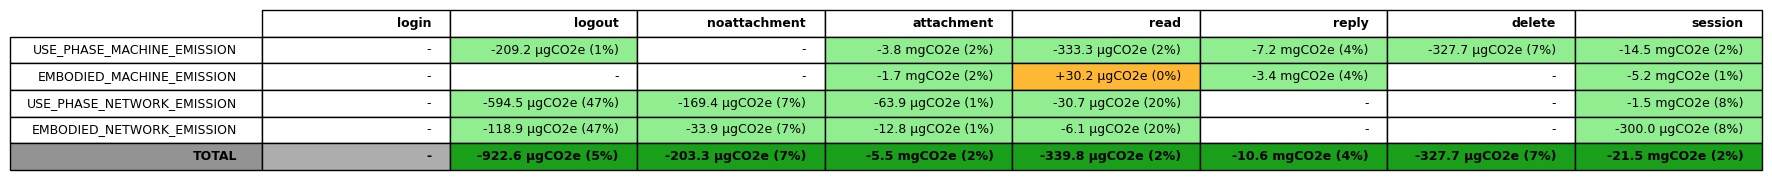

Effect of using Adblock - Proton (CO2e)


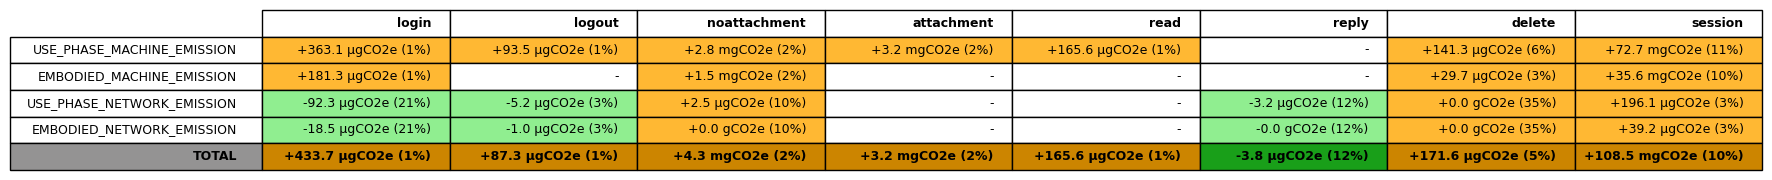

Effect of using PGP - MySolution (CO2e)


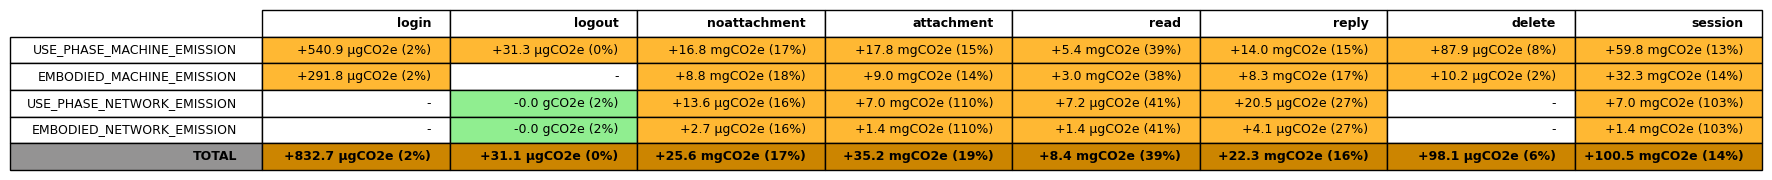

Effect of using Proton instead of Gmail (CO2e)


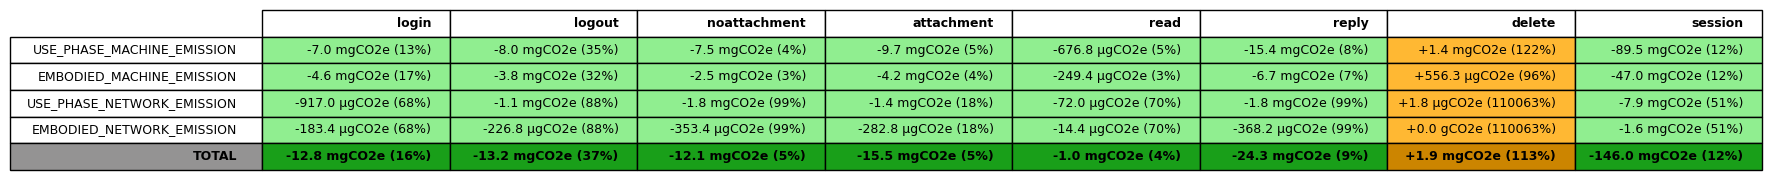

Effect of using Proton instead of Outlook (CO2e)


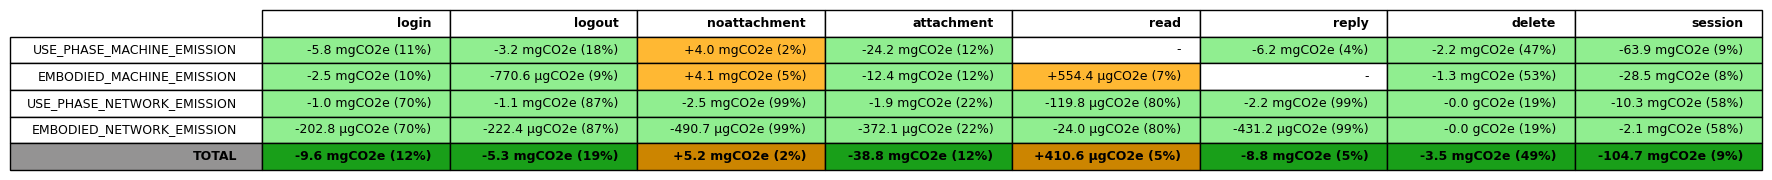

Effect of using Gmail instead of Outlook (CO2e)


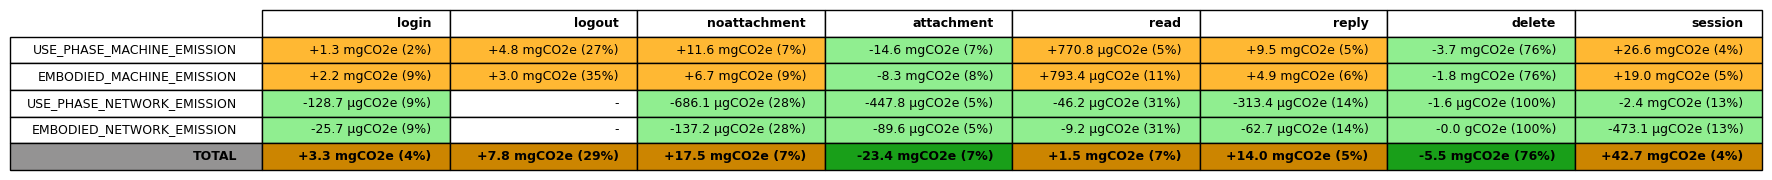

Effect of using MySolution (PGP activated) instead of Gmail (CO2e)


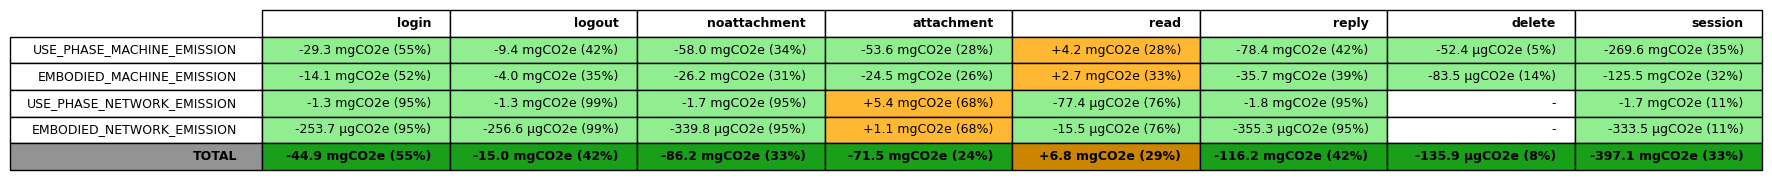

Effect of using MySolution (PGP activated) instead of Outlook (CO2e)


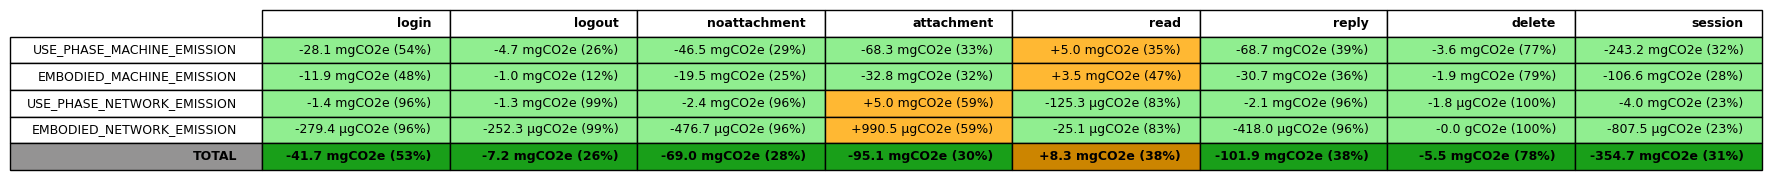

Effect of using MySolution (remotely - PGP activated) instead of Gmail (CO2e)


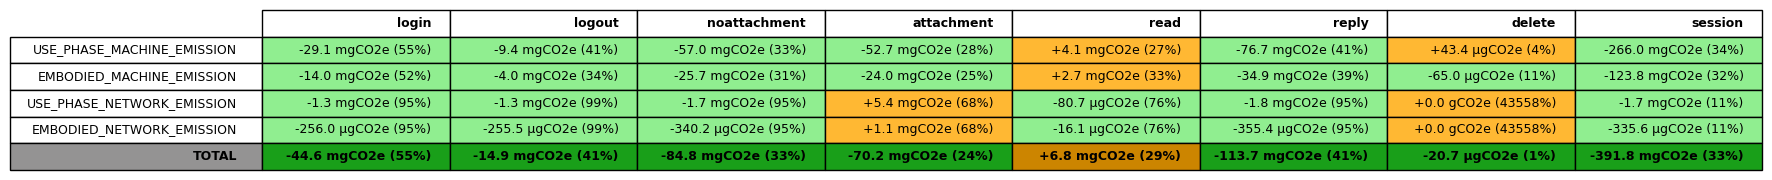

Effect of using MySolution (remotely - PGP activated) instead of Outlook (CO2e)


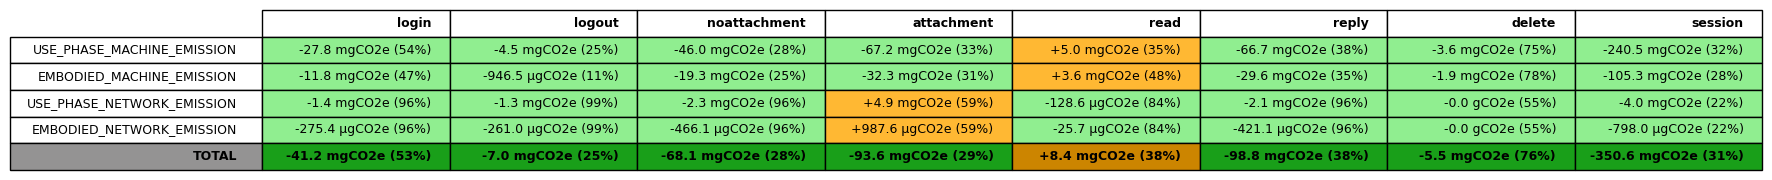

In [185]:
#################################################
############# Use-Phase Parameters ##############
#################################################
 
 
electricity_carbon_intensity = 445 # [gCO2 / kWh] World 2024 - see https://www.iea.org/reports/electricity-2025/emissions
kwh_per_J = 2.7778e-7 # 2.777e-7 [kWh/J]

energy_intensity_of_data_transfered = 0.002652 * 1e-3 # 0.002652 [kWh / GB] * 1e-3 [GB / MB] --> [kWh / MB] see https://www.green-coding.io/co2-formulas/
network_emissions = energy_intensity_of_data_transfered * electricity_carbon_intensity # [gCO2 / MB]


#################################################
############# Embodied Parameters ###############
#################################################

# --- User Side :

TE = 200000 # [gCO2] - see "https://www.sciencedirect.com/science/article/pii/S1364032123002794"
EL = 4.5 * 365 * 24 * 3600 # 4 years in seconds - see "https://www.hp.com/us-en/shop/tech-takes/average-computer-lifespan"
RS = 1 # We consider email sessions on a laptop so no virtualisation here.

# --- Network Side :

embodied_to_use_phase_ratio = 31/155  # [MtonneCO2] embodied / [MtonneCO2] use phase - see Table 8 of Malmodin et al. "https://doi.org/10.1016/j.telpol.2023.102701"

#-----------------------------------------------------------------------------------------------------------------------------------------------


for title, comparison_pair in comparisons.items():

    independence = True if 'against' in title else False
    user_gains, user_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['ESTIMATED_MACHINE_ENERGY'])
    network_gains, network_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['NETWORK_IO'])
    
    # --- USE Phase :
    CO2_user_gain = user_gains * electricity_carbon_intensity * kwh_per_J  # [gCO2] = [J] * [gCO2 / kWh] * [kWh / J]
    CO2_network_gain = network_gains * network_emissions
    # --- Embodied :
    TR_gains, TR_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['DURATION'])
    embodied_CO2_user_gain = TE * (TR_gains / EL) * RS
    embodied_CO2_network_gain = CO2_network_gain * embodied_to_use_phase_ratio

    # Combine all CO2 gains into a single DataFrame
    CO2_gain = pd.DataFrame(index=TOTALS, columns=FUNCTIONAL_UNITS)
    CO2_gain.loc['USE_PHASE_MACHINE_EMISSION'] = CO2_user_gain.iloc[0, :]
    CO2_gain.loc['EMBODIED_MACHINE_EMISSION'] = embodied_CO2_user_gain.iloc[0, :]
    CO2_gain.loc['USE_PHASE_NETWORK_EMISSION'] = CO2_network_gain.iloc[0, :]
    CO2_gain.loc['EMBODIED_NETWORK_EMISSION'] = embodied_CO2_network_gain.iloc[0, :]
    

    CO2_gain_percentage = pd.DataFrame(index=TOTALS, columns=FUNCTIONAL_UNITS)
    CO2_gain_percentage.loc['USE_PHASE_MACHINE_EMISSION'] = user_percentage_gains.iloc[0, :]
    CO2_gain_percentage.loc['EMBODIED_MACHINE_EMISSION'] = TR_percentage_gains.iloc[0, :]
    CO2_gain_percentage.loc['USE_PHASE_NETWORK_EMISSION'] = network_percentage_gains.iloc[0, :]
    CO2_gain_percentage.loc['EMBODIED_NETWORK_EMISSION'] = network_percentage_gains.iloc[0, :]

    # Calculate the total CO2 gain and percentage
    CO2_gain_percentage.loc['TOTAL'] = CO2_gain.sum(axis=0, skipna=True) / (
        (CO2_gain / CO2_gain_percentage.replace(0, np.nan) * 100).sum(axis=0, skipna=True).replace(0, np.nan)
    ).replace(0, np.nan) * 100
    CO2_gain.loc['TOTAL'] = CO2_gain.sum(axis=0, skipna=True).replace(0, np.nan)
    

    # Display the gains and plot them
    plot_gains(gains=CO2_gain, percentage=CO2_gain_percentage, CO2=True, title=title + ' (CO2e)', figsize=(10,1), fontsize=9)



Effect of using Adblock - Outlook for all ULB Outlook users in a year (gCO2)


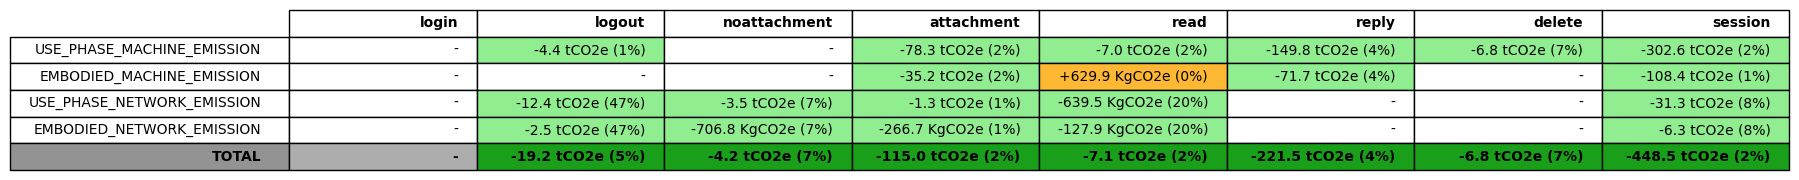


Effect of using Proton instead of Outlook for all ULB Outlook users in a year (gCO2)


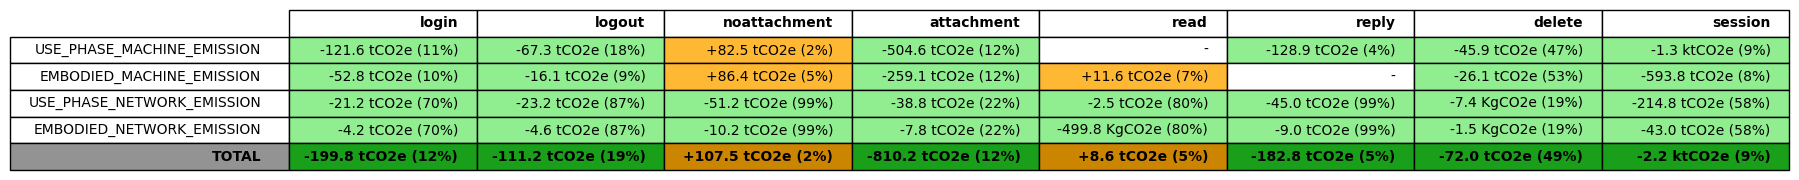


Effect of using Gmail instead of Outlook for all ULB Outlook users in a year (gCO2)


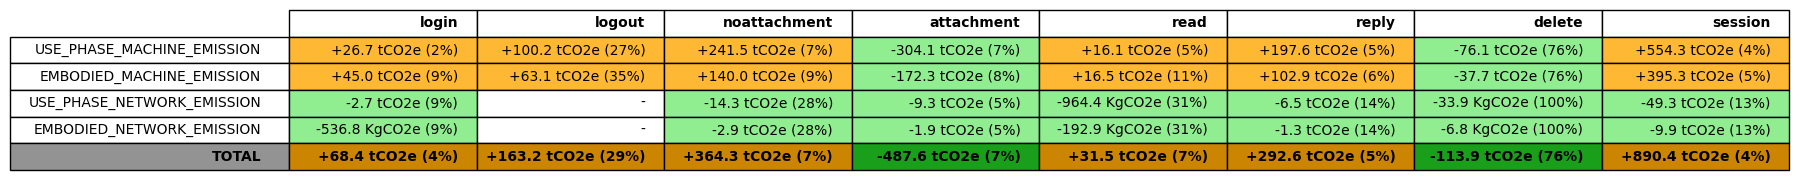


Effect of using MySolution (PGP activated) instead of Outlook for all ULB Outlook users in a year (gCO2)


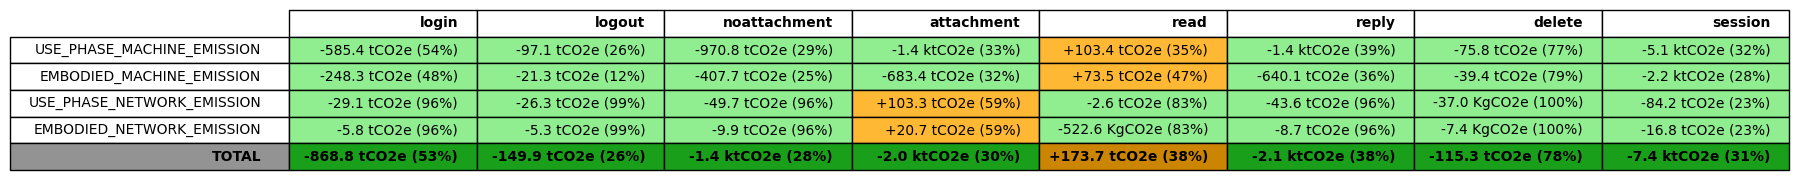


Effect of using MySolution (remotely - PGP activated) instead of Outlook for all ULB Outlook users in a year (gCO2)


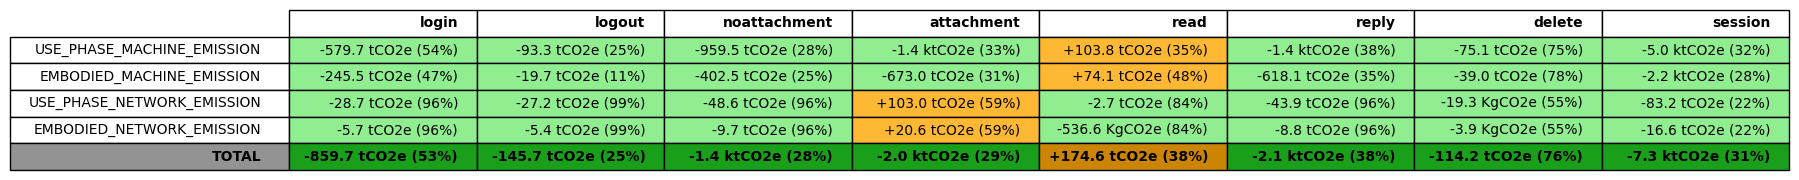

In [183]:
#################################################
######## Example of a kind of Estimate ##########
#################################################

outlook_users = 4e8
fraction = 1/7 # 1 session per week
days = 365

for title, comparison_pair in comparisons.items():
    if 'Outlook' in title:
        independence = True if 'against' in title else False
        user_gains, user_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['ESTIMATED_MACHINE_ENERGY'])
        network_gains, network_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['NETWORK_IO'])

        # --- USE Phase :
        CO2_user_gain = user_gains * electricity_carbon_intensity * kwh_per_J  # [gCO2] = [J] * [gCO2 / kWh] * [kWh / J]
        CO2_network_gain = network_gains * network_emissions
        # --- Embodied :
        TR_gains, TR_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['DURATION'])
        embodied_CO2_user_gain = TE * (TR_gains / EL) * RS
        embodied_CO2_network_gain = CO2_network_gain * embodied_to_use_phase_ratio

        # Combine all CO2 gains into a single DataFrame
        CO2_gain = pd.DataFrame(index=TOTALS, columns=FUNCTIONAL_UNITS)
        CO2_gain.loc['USE_PHASE_MACHINE_EMISSION'] = CO2_user_gain.iloc[0, :]
        CO2_gain.loc['EMBODIED_MACHINE_EMISSION'] = embodied_CO2_user_gain.iloc[0, :]
        CO2_gain.loc['USE_PHASE_NETWORK_EMISSION'] = CO2_network_gain.iloc[0, :]
        CO2_gain.loc['EMBODIED_NETWORK_EMISSION'] = embodied_CO2_network_gain.iloc[0, :]

        # Combine all CO2 gains into a single DataFrame
        CO2_gain = pd.DataFrame(index=TOTALS, columns=FUNCTIONAL_UNITS)
        CO2_gain.loc['USE_PHASE_MACHINE_EMISSION'] = CO2_user_gain.iloc[0, :]
        CO2_gain.loc['EMBODIED_MACHINE_EMISSION'] = embodied_CO2_user_gain.iloc[0, :]
        CO2_gain.loc['USE_PHASE_NETWORK_EMISSION'] = CO2_network_gain.iloc[0, :]
        CO2_gain.loc['EMBODIED_NETWORK_EMISSION'] = embodied_CO2_network_gain.iloc[0, :]
        
        CO2_gain_percentage = pd.DataFrame(index=TOTALS, columns=FUNCTIONAL_UNITS)
        CO2_gain_percentage.loc['USE_PHASE_MACHINE_EMISSION'] = user_percentage_gains.iloc[0, :]
        CO2_gain_percentage.loc['EMBODIED_MACHINE_EMISSION'] = TR_percentage_gains.iloc[0, :]
        CO2_gain_percentage.loc['USE_PHASE_NETWORK_EMISSION'] = network_percentage_gains.iloc[0, :]
        CO2_gain_percentage.loc['EMBODIED_NETWORK_EMISSION'] = network_percentage_gains.iloc[0, :]

        # Calculate the total CO2 gain and percentage
        CO2_gain_percentage.loc['TOTAL'] = CO2_gain.sum(axis=0, skipna=True) / (
            (CO2_gain / CO2_gain_percentage.replace(0, np.nan) * 100).sum(axis=0, skipna=True).replace(0, np.nan)
        ) * 100
        CO2_gain.loc['TOTAL'] = CO2_gain.sum(axis=0, skipna=True).replace(0, np.nan)
        
        CO2_gain = CO2_gain * outlook_users * fraction * days

        print()
        plot_gains(gains=CO2_gain, percentage=CO2_gain_percentage, CO2=True, title=title + ' for all ULB Outlook users in a year (gCO2)', figsize=(10,1), fontsize=10)
